# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 

Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm

In [2]:
!nvidia-smi

Tue Mar 21 01:16:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [5]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [6]:
testset, trainset

(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ), Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

## Data Preprocessing

In [7]:
BATCH_SIZE = 8
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

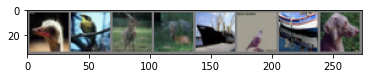

bird  bird  deer  deer  ship  bird  ship  dog  


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


## Model

In [9]:
# Parameters 


N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

In [11]:
class Backbone(nn.Module):

  def __init__(self, img_size=IMG_DIM, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
    super(Backbone, self).__init__()

    # Boolean to print debug logs.
    self.debug = debug

    self.spaitial_average_pool = nn.AvgPool2d(kernel_size=img_size)
    self.linear = nn.Sequential(
        nn.Linear(in_features=in_channels, out_features=k, bias=False),   # Question, can this be MLP?
        #nn.Tanh(),
        # nn.LeakyReLU(),
        # nn.Linear(in_features=k, out_features=k, bias=True),  
        # nn.ReLU(),
        nn.Sigmoid(),      # Non Linear Activation
    )
    # self.non_linear = nn.Sigmoid()       # Non Linear Activation
    # self.non_linear = nn.ReLU()

    self.conv2ds = nn.ModuleList([
        nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
        )
        for _ in range(k)
    ])

  def forward(self, x):
    sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"{sap_out.shape=}")

    g_out = self.linear(sap_out)
    #if self.debug: print(f"{lin_out.shape=}")

    #g_out = self.non_linear(lin_out)
    if self.debug: print(f"{g_out.shape=}")
    if self.debug: print(f"{g_out=}")

    outs = list()
    for a, conv2d in zip(g_out.transpose(0, 1), self.conv2ds):
      c_out = conv2d(x)
      if self.debug: print(f"{c_out.shape=}")
      if self.debug: print(f"{a.shape=}, \n{a=}")

      out = a.reshape(x.shape[0], 1, 1, 1)*c_out
      if self.debug: print(f"{out.shape=}")
      outs.append(out)
      #outs.append(c_out)
      
    out = sum(outs)
    if self.debug: print(f"{out.shape=}")

    return out

In [12]:
EPOCHS = 3
BATCH_SIZE = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


backbone = Backbone(img_size=IMG_DIM, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=True)

print(backbone)
for x, label in trainloader:
    print(f"{x.shape=}")
    out = backbone(x)
    break

Backbone(
  (spaitial_average_pool): AvgPool2d(kernel_size=32, stride=32, padding=0)
  (linear): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=False)
    (1): Sigmoid()
  )
  (conv2ds): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(

In [13]:
IMG_SIZE = 32

def find_img_size(initial_img_size=32, depth=4, kernel_size=3, stride=1, pool=2):
    img_sizes = list()
    for i in range(depth):
        dim = initial_img_size
        for d in range(i):
            dim = (dim - kernel_size) // stride
        img_sizes.append(dim)
        
    return img_sizes

find_img_size()

[32, 29, 26, 23]

In [14]:
class Model(nn.Module):

  def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
    super(Model, self).__init__()

    # Boolean to print debug logs.
    self.debug = debug
    self.Ks = Ks
    self.channels = channels
    self.img_sizes = [(IMG_DIM + (STRIDE-kernel_size)*i) for i in range(n+1)]
    self.img_sizes = find_img_size(initial_img_size=IMG_DIM, depth=n+1, kernel_size=kernel_size, stride=1, pool=2)

    if self.debug: print(f"{self.channels=}")
    if self.debug: print(f"{self.img_sizes=}")
    if self.debug: print(f"{self.Ks=}")
    if self.debug: print(f"{n=}")

    self.backbones = nn.ModuleList([
        Backbone(
            img_size=self.img_sizes[i], 
            in_channels=self.channels[i], 
            out_channels=self.channels[i+1], 
            kernel_size=kernel_size, 
            k=self.Ks[i], 
            debug=debug
        ) 
        for i in range(n)
    ])

    self.spaitial_average_pool = nn.AvgPool2d(kernel_size=self.img_sizes[-1])
    self.linear = nn.Sequential(
        # nn.Linear(in_features=self.channels[-1], out_features=self.channels[-1] * 2 // 3, bias=False),
        # nn.Dropout(p=0.2),
        # nn.ReLU(),
        # nn.Linear(in_features=self.channels[-1] * 2 // 3, out_features=self.channels[-1] // 3, bias=False),
        # nn.Dropout(p=0.2),
        # nn.ReLU(),
        # nn.Linear(in_features=self.channels[-1] // 3, out_features=len(CLASSES), bias=False),
        nn.Linear(in_features=self.channels[-1], out_features=len(CLASSES), bias=False),
    )
    # self.linear = nn.Linear(in_features=self.channels[-1], out_features=len(CLASSES), bias=False)

  def set_debug(self, debug=True):
    self.debug = debug
    for backbone in self.backbones:
      backbone.debug = debug

  def forward(self, x):
    for backbone in self.backbones:
      x = backbone(x)
    
    f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"M: {f.shape=}")

    out = self.linear(f)
    if self.debug: print(f"M: {out.shape=}")

    return out

In [15]:
class Trainer:

  def __init__(self, model, criterion, optimizer, epochs, trainloader, testloader, logs_per_epoch=4) -> None:
    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    
    self.epochs = epochs
    self.log_step = len(trainloader) // logs_per_epoch

    self.trainloader = trainloader
    self.testloader = testloader

    self.losses = list()
    self.val_losses = list()
    self.batch_losses = list()
    
    self.val_accuracy = list()

  def train(self, use_gpu=False):

    for epoch in range(self.epochs):  # loop over the dataset multiple times

        batch_losses = list()
        running_loss = 0.0
        for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch + 1} "):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if use_gpu:
              inputs = inputs.to('cuda')
              labels = labels.to('cuda')
            
            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            # print statistics
            batch_losses.append(loss.item())
            running_loss += loss.item()
            if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                avg_loss = running_loss / self.log_step
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                running_loss = 0.0
                self.batch_losses.append(avg_loss)

        self.losses.append(sum(batch_losses) / len(batch_losses))

        print(f"Train Loss : {self.losses[-1]}")
        self.eval()

    print('Finished Training')

  def eval(self):
    correct = 0
    total = 0
    losses = list()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in self.testloader:
            images, labels = data
            if USE_GPU:
              images = images.to('cuda')
              labels = labels.to('cuda')

            # calculate outputs by running images through the network
            outputs = self.model(images)

            loss = self.criterion(outputs, labels)
            losses.append(loss.item())

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
    val_loss = sum(losses) / len(losses)
    self.val_losses.append(val_loss)

    print(f"Val Loss : {val_loss}")
    
    accuracy = correct / total
    self.val_accuracy.append(accuracy)
    print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
    
  def plot(self):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 3)

    X = np.linspace(0, len(self.losses)-1, len(self.batch_losses))
    ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', linestyle='dashed', lw=1, alpha=0.7)
    ax1.plot(self.losses, label='Train', color='C0', lw=3, alpha=1)
    ax1.plot(self.val_losses, label='Test', color='C1', lw=3, alpha=1)
    ax1.legend()
    ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
    
    ax2.plot(self.val_accuracy, label="Test", color='C1', lw=3, alpha=1)
    ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
    ax2.legend()
    plt.tight_layout()
    fig.show()
    

In [16]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

## Experiment

In [22]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 3
STRIDE = 1

# channels = [IMG_CHANNELS, 16, 32, 64, 64] #20, 25, 30]
# channels = [IMG_CHANNELS, 4, 8, 16, ]
# channels = [IMG_CHANNELS, 5, 7, 9, 11, 13]
channels = [IMG_CHANNELS, 32, 64, 128, 256, 512, ] #19, ]
# Ks = channels[1:]
Ks = [3] * (len(channels) - 1)
N = len(channels) - 1

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)
if USE_GPU: model.to('cuda')

model

self.channels=[3, 32, 64, 128, 256, 512]
self.img_sizes=[32, 29, 26, 23, 20, 17]
self.Ks=[3, 3, 3, 3, 3]
n=5


Model(
  (backbones): ModuleList(
    (0): Backbone(
      (spaitial_average_pool): AvgPool2d(kernel_size=32, stride=32, padding=0)
      (linear): Sequential(
        (0): Linear(in_features=3, out_features=3, bias=False)
        (1): Sigmoid()
      )
      (conv2ds): ModuleList(
        (0): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
        )
        (1): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
        )
        (2): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
        )
      )
    )
    (1): Backbone(
      (spaitial_average_pool): AvgPool2d(kernel_siz

In [23]:
# Init optimizer 

LR = 1e-4 #1e-3, 1e-4
MOMENTUM = 0.9 #0.9


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

model.set_debug(False)

In [24]:
# Init Trainer

EPOCHS = 3
BATCH_SIZE = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=EPOCHS, 
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

Epoch 1 :   0%|          | 0/782 [00:00<?, ?it/s]

[1,   195] loss: 2.082
[1,   390] loss: 1.838
[1,   585] loss: 1.738
[1,   780] loss: 1.685
Train Loss : 1.8350977124765402
Val Loss : 1.6214924967213042
Accuracy of the network on the 10000 test images: 39.05 %


Epoch 2 :   0%|          | 0/782 [00:00<?, ?it/s]

[2,   195] loss: 1.625
[2,   390] loss: 1.567
[2,   585] loss: 1.551
[2,   780] loss: 1.519
Train Loss : 1.565363917966633
Val Loss : 1.5315677800755592
Accuracy of the network on the 10000 test images: 44.46 %


Epoch 3 :   0%|          | 0/782 [00:00<?, ?it/s]

[3,   195] loss: 1.484
[3,   390] loss: 1.460
[3,   585] loss: 1.456
[3,   780] loss: 1.401
Train Loss : 1.4502762542356311
Val Loss : 1.4281135577305106
Accuracy of the network on the 10000 test images: 48.22 %


Epoch 4 :   0%|          | 0/782 [00:00<?, ?it/s]

[4,   195] loss: 1.393
[4,   390] loss: 1.378
[4,   585] loss: 1.357
[4,   780] loss: 1.334
Train Loss : 1.3654597527383234
Val Loss : 1.3511490389040322
Accuracy of the network on the 10000 test images: 51.67 %


Epoch 5 :   0%|          | 0/782 [00:00<?, ?it/s]

[5,   195] loss: 1.317
[5,   390] loss: 1.318
[5,   585] loss: 1.263
[5,   780] loss: 1.275
Train Loss : 1.293435199562546
Val Loss : 1.2857115868550197
Accuracy of the network on the 10000 test images: 54.43 %


Epoch 6 :   0%|          | 0/782 [00:00<?, ?it/s]

[6,   195] loss: 1.258
[6,   390] loss: 1.247
[6,   585] loss: 1.223
[6,   780] loss: 1.213
Train Loss : 1.2349798840939845
Val Loss : 1.1866958851267577
Accuracy of the network on the 10000 test images: 57.92 %


Epoch 7 :   0%|          | 0/782 [00:00<?, ?it/s]

[7,   195] loss: 1.208
[7,   390] loss: 1.184
[7,   585] loss: 1.161
[7,   780] loss: 1.161
Train Loss : 1.178282497484056
Val Loss : 1.1680268584542972
Accuracy of the network on the 10000 test images: 58.89 %


Epoch 8 :   0%|          | 0/782 [00:00<?, ?it/s]

[8,   195] loss: 1.143
[8,   390] loss: 1.128
[8,   585] loss: 1.136
[8,   780] loss: 1.134
Train Loss : 1.1345995568558382
Val Loss : 1.160542007464512
Accuracy of the network on the 10000 test images: 58.61 %


Epoch 9 :   0%|          | 0/782 [00:00<?, ?it/s]

[9,   195] loss: 1.100
[9,   390] loss: 1.087
[9,   585] loss: 1.078
[9,   780] loss: 1.070
Train Loss : 1.0834817581469445
Val Loss : 1.125551395355516
Accuracy of the network on the 10000 test images: 60.50 %


Epoch 10 :   0%|          | 0/782 [00:00<?, ?it/s]

[10,   195] loss: 1.063
[10,   390] loss: 1.045
[10,   585] loss: 1.049
[10,   780] loss: 1.024
Train Loss : 1.0453133614319365
Val Loss : 1.1024174732007799
Accuracy of the network on the 10000 test images: 61.34 %


Epoch 11 :   0%|          | 0/782 [00:00<?, ?it/s]

[11,   195] loss: 1.022
[11,   390] loss: 1.014
[11,   585] loss: 1.017
[11,   780] loss: 0.994
Train Loss : 1.0121787180528616
Val Loss : 1.017370457482186
Accuracy of the network on the 10000 test images: 64.15 %


Epoch 12 :   0%|          | 0/782 [00:00<?, ?it/s]

[12,   195] loss: 0.986
[12,   390] loss: 0.984
[12,   585] loss: 0.979
[12,   780] loss: 0.947
Train Loss : 0.9738674433639897
Val Loss : 0.9788010473463945
Accuracy of the network on the 10000 test images: 65.53 %


Epoch 13 :   0%|          | 0/782 [00:00<?, ?it/s]

[13,   195] loss: 0.951
[13,   390] loss: 0.933
[13,   585] loss: 0.935
[13,   780] loss: 0.955
Train Loss : 0.9435869299847147
Val Loss : 0.988756787625088
Accuracy of the network on the 10000 test images: 65.43 %


Epoch 14 :   0%|          | 0/782 [00:00<?, ?it/s]

[14,   195] loss: 0.930
[14,   390] loss: 0.920
[14,   585] loss: 0.931
[14,   780] loss: 0.909
Train Loss : 0.9224726707124344
Val Loss : 0.9621982301116749
Accuracy of the network on the 10000 test images: 66.34 %


Epoch 15 :   0%|          | 0/782 [00:00<?, ?it/s]

[15,   195] loss: 0.888
[15,   390] loss: 0.894
[15,   585] loss: 0.890
[15,   780] loss: 0.895
Train Loss : 0.8917913458993673
Val Loss : 0.9269669044549298
Accuracy of the network on the 10000 test images: 66.86 %


Epoch 16 :   0%|          | 0/782 [00:00<?, ?it/s]

[16,   195] loss: 0.881
[16,   390] loss: 0.854
[16,   585] loss: 0.872
[16,   780] loss: 0.853
Train Loss : 0.8651898339428865
Val Loss : 0.9022663315390326
Accuracy of the network on the 10000 test images: 68.28 %


Epoch 17 :   0%|          | 0/782 [00:00<?, ?it/s]

[17,   195] loss: 0.835
[17,   390] loss: 0.826
[17,   585] loss: 0.834
[17,   780] loss: 0.837
Train Loss : 0.8324958946165222
Val Loss : 0.8751117032804306
Accuracy of the network on the 10000 test images: 69.52 %


Epoch 18 :   0%|          | 0/782 [00:00<?, ?it/s]

[18,   195] loss: 0.809
[18,   390] loss: 0.819
[18,   585] loss: 0.797
[18,   780] loss: 0.821
Train Loss : 0.8115075592647123
Val Loss : 0.9510407390867829
Accuracy of the network on the 10000 test images: 66.54 %


Epoch 19 :   0%|          | 0/782 [00:00<?, ?it/s]

[19,   195] loss: 0.799
[19,   390] loss: 0.791
[19,   585] loss: 0.781
[19,   780] loss: 0.793
Train Loss : 0.7910943363252503
Val Loss : 0.8687269923033988
Accuracy of the network on the 10000 test images: 69.93 %


Epoch 20 :   0%|          | 0/782 [00:00<?, ?it/s]

[20,   195] loss: 0.767
[20,   390] loss: 0.771
[20,   585] loss: 0.767
[20,   780] loss: 0.762
Train Loss : 0.7669791439381402
Val Loss : 0.8601547434071827
Accuracy of the network on the 10000 test images: 69.84 %


Epoch 21 :   0%|          | 0/782 [00:00<?, ?it/s]

[21,   195] loss: 0.749
[21,   390] loss: 0.756
[21,   585] loss: 0.739
[21,   780] loss: 0.736
Train Loss : 0.7454738318920135
Val Loss : 0.8159233811934283
Accuracy of the network on the 10000 test images: 71.64 %


Epoch 22 :   0%|          | 0/782 [00:00<?, ?it/s]

[22,   195] loss: 0.717
[22,   390] loss: 0.729
[22,   585] loss: 0.725
[22,   780] loss: 0.743
Train Loss : 0.7286998622710138
Val Loss : 0.8139150116094358
Accuracy of the network on the 10000 test images: 71.62 %


Epoch 23 :   0%|          | 0/782 [00:00<?, ?it/s]

[23,   195] loss: 0.696
[23,   390] loss: 0.715
[23,   585] loss: 0.695
[23,   780] loss: 0.711
Train Loss : 0.704580113749065
Val Loss : 0.777834772873836
Accuracy of the network on the 10000 test images: 72.61 %


Epoch 24 :   0%|          | 0/782 [00:00<?, ?it/s]

[24,   195] loss: 0.671
[24,   390] loss: 0.693
[24,   585] loss: 0.677
[24,   780] loss: 0.702
Train Loss : 0.6851505931762173
Val Loss : 0.7511428279481875
Accuracy of the network on the 10000 test images: 74.21 %


Epoch 25 :   0%|          | 0/782 [00:00<?, ?it/s]

[25,   195] loss: 0.657
[25,   390] loss: 0.664
[25,   585] loss: 0.668
[25,   780] loss: 0.654
Train Loss : 0.6605658045281535
Val Loss : 0.793502434233951
Accuracy of the network on the 10000 test images: 72.85 %


Epoch 26 :   0%|          | 0/782 [00:00<?, ?it/s]

[26,   195] loss: 0.633
[26,   390] loss: 0.649
[26,   585] loss: 0.645
[26,   780] loss: 0.648
Train Loss : 0.6438345077550015
Val Loss : 0.7554835844191776
Accuracy of the network on the 10000 test images: 73.85 %


Epoch 27 :   0%|          | 0/782 [00:00<?, ?it/s]

[27,   195] loss: 0.619
[27,   390] loss: 0.638
[27,   585] loss: 0.621
[27,   780] loss: 0.612
Train Loss : 0.6220905947334626
Val Loss : 0.7463256542090397
Accuracy of the network on the 10000 test images: 74.28 %


Epoch 28 :   0%|          | 0/782 [00:00<?, ?it/s]

[28,   195] loss: 0.586
[28,   390] loss: 0.609
[28,   585] loss: 0.601
[28,   780] loss: 0.594
Train Loss : 0.5972544489156865
Val Loss : 0.7841546436783614
Accuracy of the network on the 10000 test images: 73.42 %


Epoch 29 :   0%|          | 0/782 [00:00<?, ?it/s]

[29,   195] loss: 0.579
[29,   390] loss: 0.584
[29,   585] loss: 0.578
[29,   780] loss: 0.572
Train Loss : 0.5778015751363067
Val Loss : 0.7518869264490285
Accuracy of the network on the 10000 test images: 74.26 %


Epoch 30 :   0%|          | 0/782 [00:00<?, ?it/s]

[30,   195] loss: 0.558
[30,   390] loss: 0.555
[30,   585] loss: 0.558
[30,   780] loss: 0.564
Train Loss : 0.5587006281403935
Val Loss : 0.6972650397735037
Accuracy of the network on the 10000 test images: 76.22 %


Epoch 31 :   0%|          | 0/782 [00:00<?, ?it/s]

[31,   195] loss: 0.538
[31,   390] loss: 0.546
[31,   585] loss: 0.536
[31,   780] loss: 0.536
Train Loss : 0.5392712713469325
Val Loss : 0.6976255983304066
Accuracy of the network on the 10000 test images: 76.37 %


Epoch 32 :   0%|          | 0/782 [00:00<?, ?it/s]

[32,   195] loss: 0.511
[32,   390] loss: 0.523
[32,   585] loss: 0.527
[32,   780] loss: 0.530
Train Loss : 0.5229364981889115
Val Loss : 0.7233586930165625
Accuracy of the network on the 10000 test images: 75.60 %


Epoch 33 :   0%|          | 0/782 [00:00<?, ?it/s]

[33,   195] loss: 0.505
[33,   390] loss: 0.501
[33,   585] loss: 0.497
[33,   780] loss: 0.499
Train Loss : 0.5002624676050738
Val Loss : 0.7191095073131999
Accuracy of the network on the 10000 test images: 75.63 %


Epoch 34 :   0%|          | 0/782 [00:00<?, ?it/s]

[34,   195] loss: 0.469
[34,   390] loss: 0.473
[34,   585] loss: 0.475
[34,   780] loss: 0.489
Train Loss : 0.4768407068136708
Val Loss : 0.6741580198145216
Accuracy of the network on the 10000 test images: 77.16 %


Epoch 35 :   0%|          | 0/782 [00:00<?, ?it/s]

[35,   195] loss: 0.455
[35,   390] loss: 0.460
[35,   585] loss: 0.462
[35,   780] loss: 0.470
Train Loss : 0.4621659260043098
Val Loss : 0.6755179975442825
Accuracy of the network on the 10000 test images: 76.74 %


Epoch 36 :   0%|          | 0/782 [00:00<?, ?it/s]

[36,   195] loss: 0.435
[36,   390] loss: 0.439
[36,   585] loss: 0.445
[36,   780] loss: 0.450
Train Loss : 0.44248941658860275
Val Loss : 0.6807894315689232
Accuracy of the network on the 10000 test images: 77.20 %


Epoch 37 :   0%|          | 0/782 [00:00<?, ?it/s]

[37,   195] loss: 0.419
[37,   390] loss: 0.409
[37,   585] loss: 0.428
[37,   780] loss: 0.430
Train Loss : 0.4209637267662741
Val Loss : 0.6892609203317362
Accuracy of the network on the 10000 test images: 77.59 %


Epoch 38 :   0%|          | 0/782 [00:00<?, ?it/s]

[38,   195] loss: 0.391
[38,   390] loss: 0.419
[38,   585] loss: 0.397
[38,   780] loss: 0.413
Train Loss : 0.4045963045543112
Val Loss : 0.7078969231836355
Accuracy of the network on the 10000 test images: 76.86 %


Epoch 39 :   0%|          | 0/782 [00:00<?, ?it/s]

[39,   195] loss: 0.385
[39,   390] loss: 0.387
[39,   585] loss: 0.377
[39,   780] loss: 0.381
Train Loss : 0.38197307393450264
Val Loss : 0.709541810356128
Accuracy of the network on the 10000 test images: 76.60 %


Epoch 40 :   0%|          | 0/782 [00:00<?, ?it/s]

[40,   195] loss: 0.349
[40,   390] loss: 0.370
[40,   585] loss: 0.374
[40,   780] loss: 0.380
Train Loss : 0.3683991512412305
Val Loss : 0.6860596628705408
Accuracy of the network on the 10000 test images: 77.70 %
Finished Training


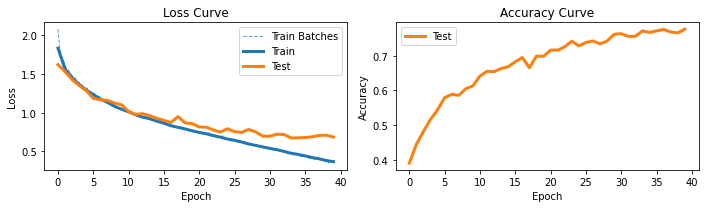

In [25]:
trainer.epochs = 40

trainer.train(use_gpu=USE_GPU)
trainer.plot()

Epoch 1 :   0%|          | 0/782 [00:00<?, ?it/s]

[1,   195] loss: 1.106
[1,   390] loss: 1.087
[1,   585] loss: 1.072
[1,   780] loss: 1.053
Train Loss : 1.0794677072016479
Val Loss : 1.1104244828983476
Accuracy of the network on the 10000 test images: 60.14 %


Epoch 2 :   0%|          | 0/782 [00:00<?, ?it/s]

[2,   195] loss: 1.018
[2,   390] loss: 1.020
[2,   585] loss: 1.006
[2,   780] loss: 0.992
Train Loss : 1.0090245305729644
Val Loss : 0.9993311386958809
Accuracy of the network on the 10000 test images: 64.98 %


Epoch 3 :   0%|          | 0/782 [00:00<?, ?it/s]

[3,   195] loss: 0.947
[3,   390] loss: 0.940
[3,   585] loss: 0.953
[3,   780] loss: 0.928
Train Loss : 0.9420282034312978
Val Loss : 0.9510167229707074
Accuracy of the network on the 10000 test images: 66.50 %


Epoch 4 :   0%|          | 0/782 [00:00<?, ?it/s]

[4,   195] loss: 0.882
[4,   390] loss: 0.882
[4,   585] loss: 0.883
[4,   780] loss: 0.889
Train Loss : 0.8844631546751007
Val Loss : 0.9223091685847872
Accuracy of the network on the 10000 test images: 67.07 %


Epoch 5 :   0%|          | 0/782 [00:00<?, ?it/s]

[5,   195] loss: 0.850
[5,   390] loss: 0.837
[5,   585] loss: 0.836
[5,   780] loss: 0.822
Train Loss : 0.8361209376769907
Val Loss : 0.8834100301098672
Accuracy of the network on the 10000 test images: 68.95 %


Epoch 6 :   0%|          | 0/782 [00:00<?, ?it/s]

[6,   195] loss: 0.793
[6,   390] loss: 0.809
[6,   585] loss: 0.792
[6,   780] loss: 0.791
Train Loss : 0.7961856994939887
Val Loss : 0.8720774149439138
Accuracy of the network on the 10000 test images: 69.31 %


Epoch 7 :   0%|          | 0/782 [00:00<?, ?it/s]

[7,   195] loss: 0.768
[7,   390] loss: 0.756
[7,   585] loss: 0.752
[7,   780] loss: 0.735
Train Loss : 0.7525343447161452
Val Loss : 0.9042799693004341
Accuracy of the network on the 10000 test images: 68.60 %
Finished Training


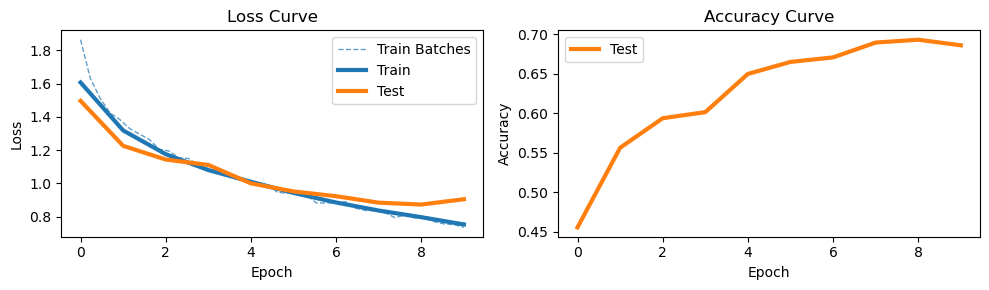

In [ ]:
trainer.epochs = 7

trainer.train(use_gpu=USE_GPU)
trainer.plot()